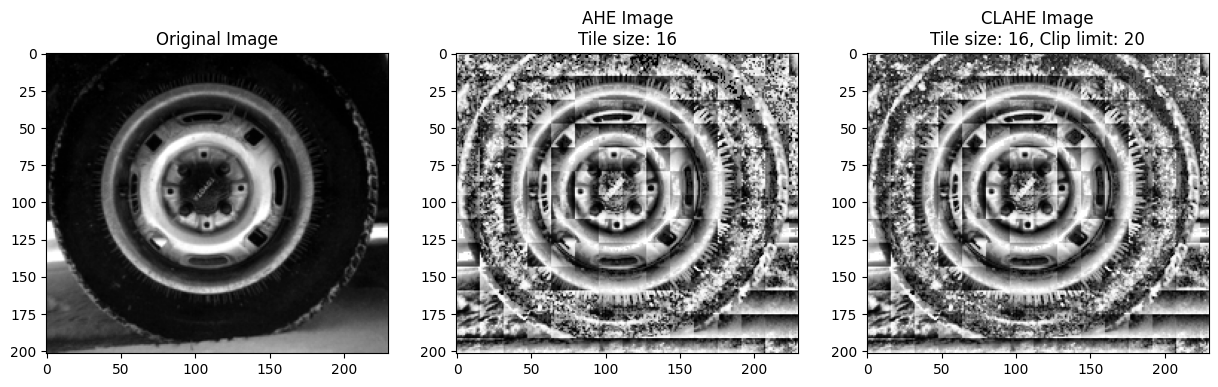

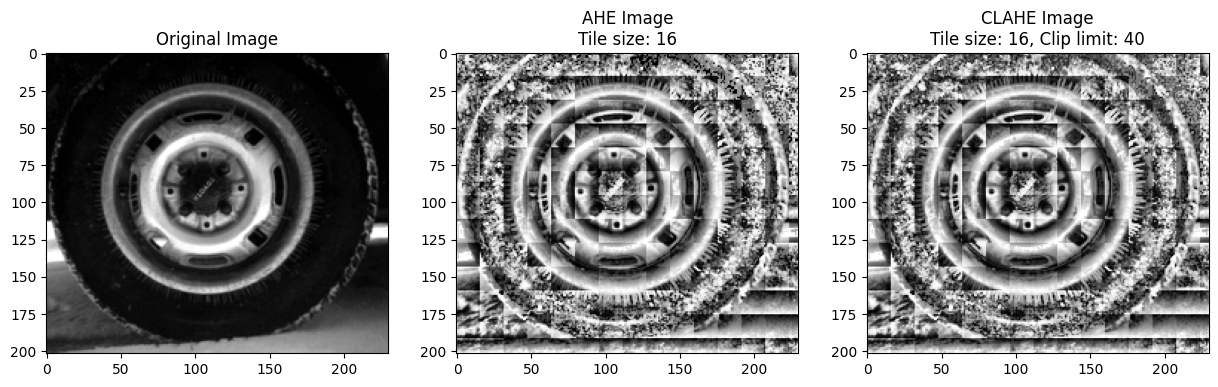

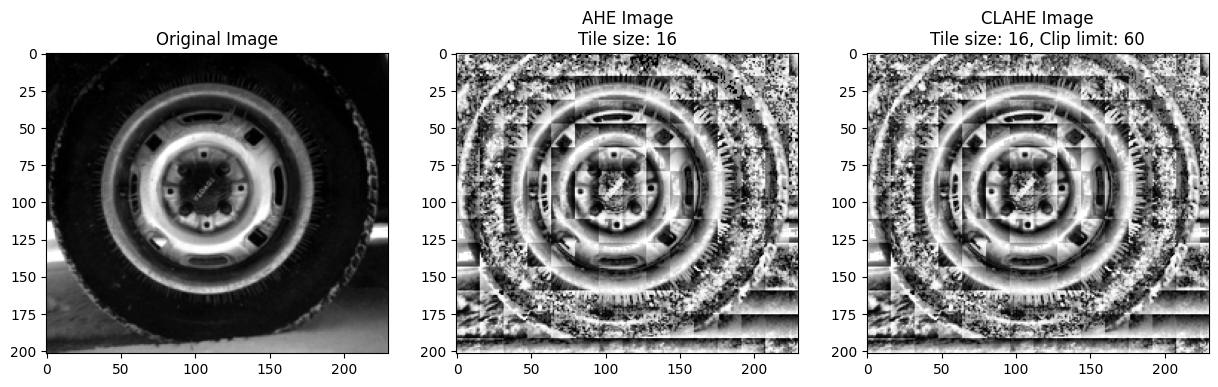

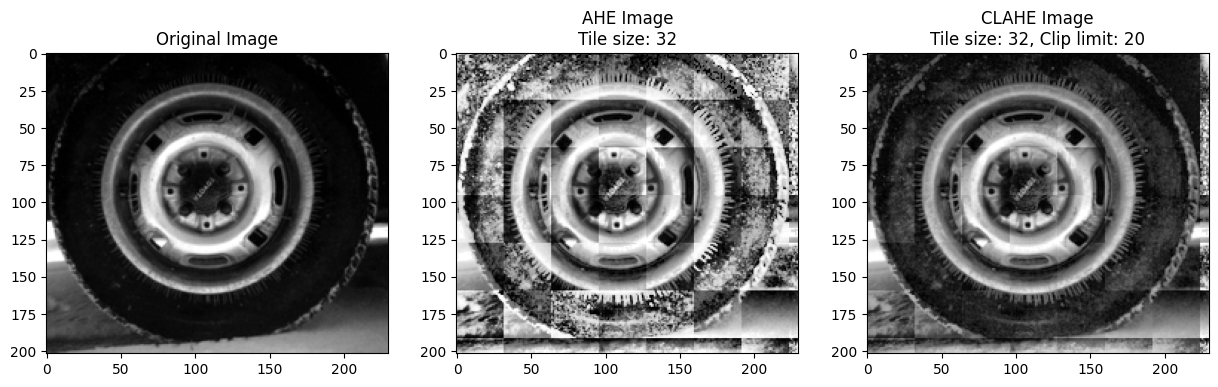

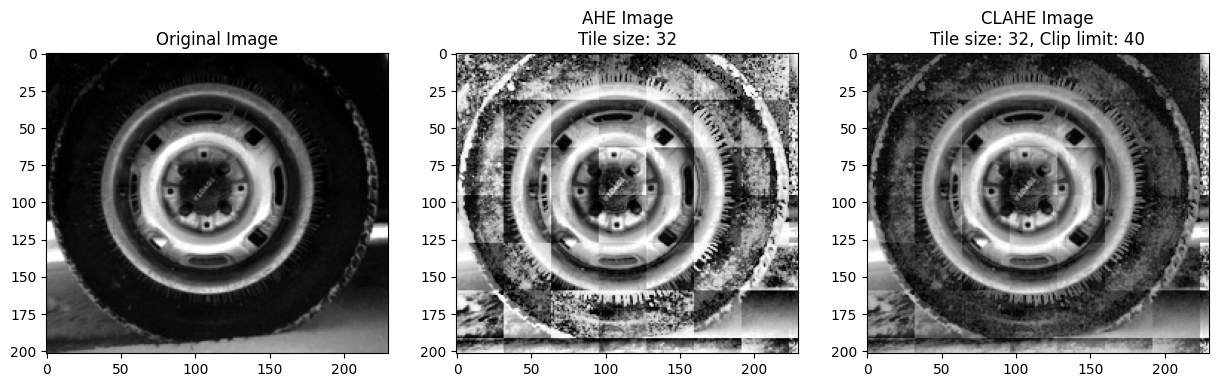

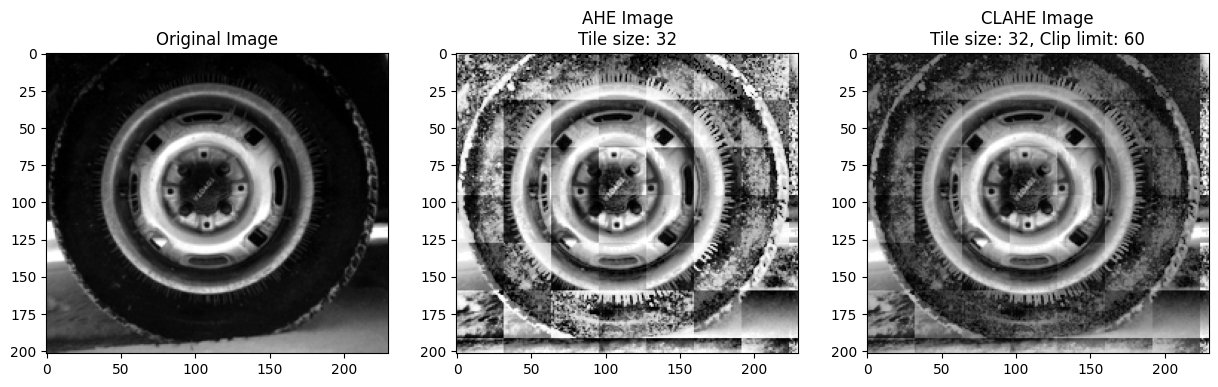

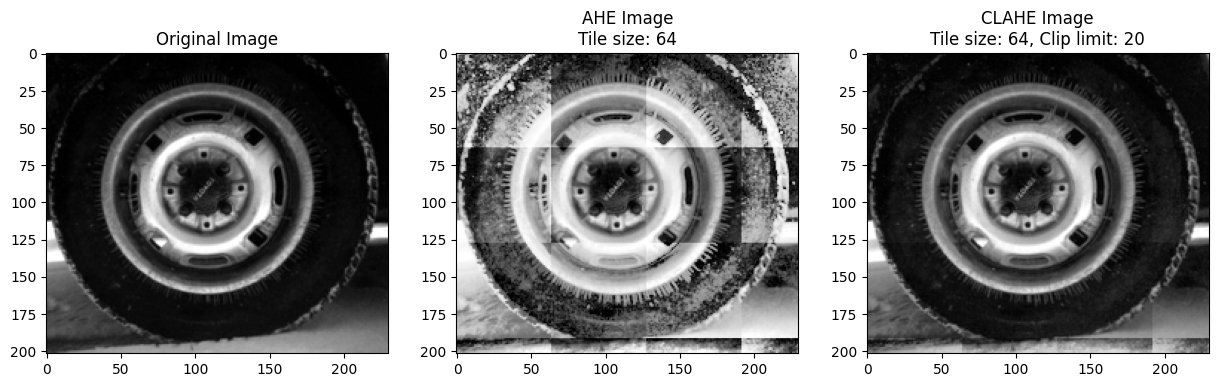

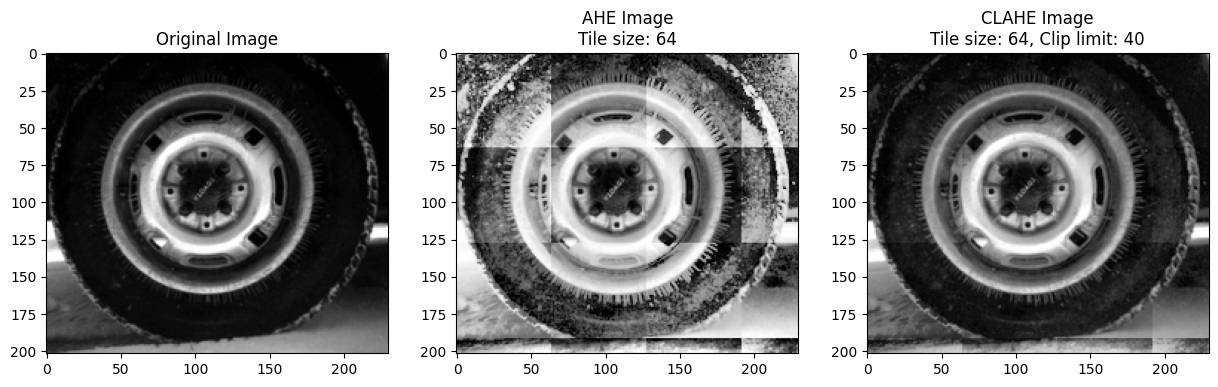

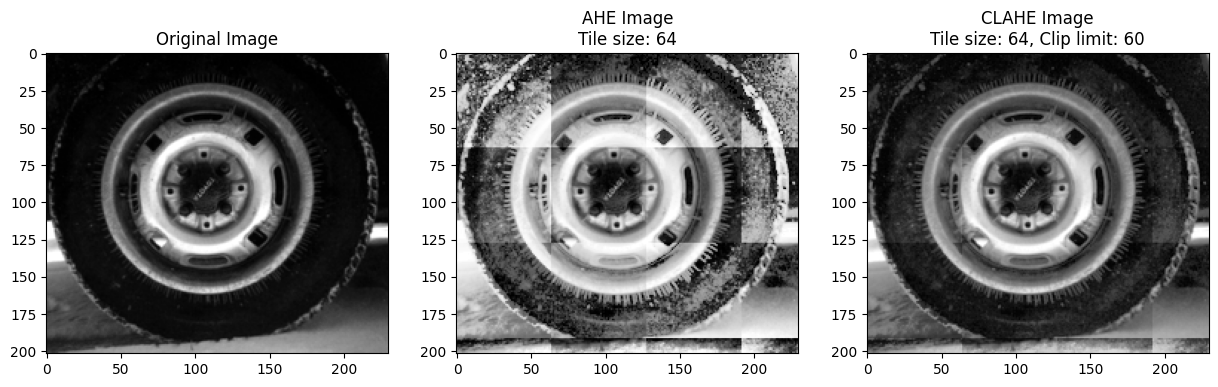

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_equalization(image):
    """ Apply simple histogram equalization to the image. """
    hist, bins = np.histogram(image.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[image]

def ahe(image, tile_size):
    """ Apply Adaptive Histogram Equalization (AHE) to the image. """
    output = np.zeros_like(image)
    n_rows, n_cols = image.shape
    for i in range(0, n_rows, tile_size):
        for j in range(0, n_cols, tile_size):
            row_end = min(i + tile_size, n_rows)
            col_end = min(j + tile_size, n_cols)
            tile = image[i:row_end, j:col_end]
            output[i:row_end, j:col_end] = histogram_equalization(tile)
    return output

def clahe(image, tile_size, clip_limit):
    """ Apply CLAHE to the image. """
    output = np.zeros_like(image)
    n_rows, n_cols = image.shape
    for i in range(0, n_rows, tile_size):
        for j in range(0, n_cols, tile_size):
            row_end = min(i + tile_size, n_rows)
            col_end = min(j + tile_size, n_cols)
            tile = image[i:row_end, j:col_end]
            tile_hist, _ = np.histogram(tile.flatten(), 256, [0,256])
            if clip_limit > 0:
                excess = max(0, tile_hist.sum() - clip_limit)
                excess_per_bin = excess // 256
                clip_hist = np.clip(tile_hist - excess_per_bin, 0, clip_limit)
                tile_hist = clip_hist + (excess_per_bin * np.ones(256))
            cdf = tile_hist.cumsum()
            cdf_normalized = cdf * 255 / cdf[-1]
            tile = cdf_normalized[tile.astype('uint8')]
            output[i:row_end, j:col_end] = tile.reshape(row_end - i, col_end - j)
    return output

image_path = 'image1.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

tile_sizes = [16, 32, 64]
clip_limits = [20, 40, 60]

# Iterate through different tile sizes and clip limits
for tile_size in tile_sizes:
    for clip_limit in clip_limits:
        ahe_image = ahe(image, tile_size)
        clahe_image = clahe(image, tile_size, clip_limit)

        # Displaying the images
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(f'Original Image')
        ax[1].imshow(ahe_image, cmap='gray')
        ax[1].set_title(f'AHE Image\nTile size: {tile_size}')
        ax[2].imshow(clahe_image, cmap='gray')
        ax[2].set_title(f'CLAHE Image\nTile size: {tile_size}, Clip limit: {clip_limit}')
        plt.show()


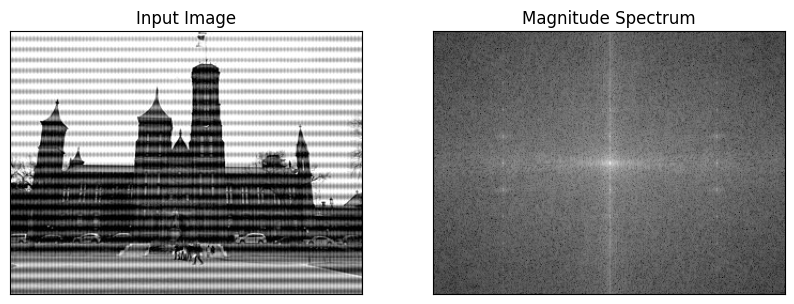

Inspect the magnitude spectrum to identify the noise. Note the threshold or coordinates.


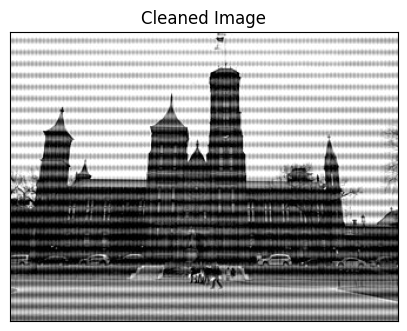

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_fourier_transform(image):
    """ Apply Fourier transform and return the magnitude spectrum and phase angle. """
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift))
    return dft_shift, magnitude_spectrum

def apply_inverse_fourier_transform(dft_shift):
    """ Apply Inverse Fourier transform to get the image back from its frequency domain representation. """
    f_ishift = np.fft.ifftshift(dft_shift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def remove_noise(dft_shift, threshold=20):
    """ Attempt to remove noise by zeroing out frequency components that are likely noise. """
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift))
    mask = magnitude_spectrum > threshold
    dft_shift[mask] = 0
    return dft_shift

# Load an image and convert to grayscale
image_path = './image2.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Fourier Transform
dft_shift, magnitude_spectrum = apply_fourier_transform(image)

# Visualize the magnitude spectrum
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

print("Inspect the magnitude spectrum to identify the noise.")


threshold = 400
dft_shift = remove_noise(dft_shift, threshold)

image_cleaned = apply_inverse_fourier_transform(dft_shift)

# Display the cleaned image
plt.figure(figsize=(5, 5))
plt.imshow(image_cleaned, cmap='gray')
plt.title('Cleaned Image'), plt.xticks([]), plt.yticks([])
plt.show()
